# 1. Install Spark Libraries

In [ ]:
!pip install findspark
!pip install pyspark
!pip show pyspark

Name: pyspark
Version: 3.2.0
Summary: Apache Spark Python API
Home-page: https://github.com/apache/spark/tree/master/python
Author: Spark Developers
Author-email: dev@spark.apache.org
License: http://www.apache.org/licenses/LICENSE-2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: py4j
Required-by: 


# 2. Install Library for Sentiment Analysis

In [ ]:
!pip install textblob
!pip install wordcloud

# 3. Install Library for EDA

In [ ]:
!pip install dataprep

# 4. Import Libraries

In [ ]:
# wordCloud : untuk membuat visualisasi dari data teks dalam bentuk wordclouds
from wordcloud import WordCloud

# textblob : untuk memproses data tekstual
from textblob import TextBlob

# nltk : untuk menghapus stop word
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# pyspark : library untuk spark
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

# library untuk tokenisasi
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.utils import shuffle

# Import Library untuk Analisis Data
import pandas as pd
import numpy as np
import re
import string
from dataprep.eda import plot
from dataprep.eda import plot_correlation
from dataprep.eda import plot_missing

# Import Library untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Pengaturan library visualisasi
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

# Import Library untuk Data Modelling
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from math import *
from sklearn.metrics import *
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!ls "/content/gdrive/My Drive/DE_Projek_Akhir"

 2021_shopee_tweet.csv		     Kelompok5_ProjectDE.ipynb	 Yunico
'DE_Projek Akhir_Kelompok 4.ipynb'   steam.csv


# 5. Create a new Spark session

In [ ]:
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [ ]:
# Cek session baru
spark

# 6. Import Data

In [ ]:
# 1. Import dalam bentuk spark dataframe
spark_data = spark.read.options(header='True', inferSchema='True', delimiter=',').csv("/content/gdrive/MyDrive/DE_Projek_Akhir/2021_shopee_tweet.csv")

In [ ]:
# Tampilkan data spark
spark_data.show(10)

+-------------------+--------------------+--------------------+
|            id_user|        shopee_tweet|          tweet_date|
+-------------------+--------------------+--------------------+
|1199264475443937281|RT @ShopeeID: Sam...|2021-12-20 04:49:...|
|1299243372540952576|RT @ShopeeID: \xf...|2021-12-20 04:49:...|
|1389400559673778176|RT @nikisbuggeopa...|2021-12-20 04:49:...|
|1465534868801351681|RT @ShopeeID: \xf...|2021-12-20 04:49:...|
|1379891895921336320|RT @nikisbuggeopa...|2021-12-20 04:49:...|
| 896159328452739072|Enjoy up to 45% O...|2021-12-20 04:49:...|
|1127807019409260544|RT @Humalife_: Re...|2021-12-20 04:49:...|
|1131356833300402176|RT @AdmirerFelici...|follow+rt\n\nEnd ...|
|1094083497566756864|RT @gaatau_gaaken...|2021-12-20 04:49:...|
|1458421310237786118|@ShopeePH YOU HAV...|2021-12-20 04:49:...|
+-------------------+--------------------+--------------------+
only showing top 10 rows



In [ ]:
# 2. Ubah ke bentuk dataframe pandas
data = spark_data.toPandas()

# 7. Exploratory Data Analysis

## 1. Check top 10 Data

In [ ]:
data.head(10)

,id_user,shopee_tweet,tweet_date
0,1199264475443937281,RT @ShopeeID: Sambut tahun baru 2022 bersama k...,2021-12-20 04:49:48+00:00
1,1299243372540952576,RT @ShopeeID: \xf0\x9f\xa7\xa1 OPPO X ASSC GIV...,2021-12-20 04:49:47+00:00
2,1389400559673778176,RT @nikisbuggeopang: 121921 Shopee Fancall \n\...,2021-12-20 04:49:47+00:00
3,1465534868801351681,RT @ShopeeID: \xf0\x9f\xa7\xa1 OPPO X ASSC GIV...,2021-12-20 04:49:48+00:00
4,1379891895921336320,RT @nikisbuggeopang: 121921 Shopee Fancall \n\...,2021-12-20 04:49:46+00:00
5,896159328452739072,Enjoy up to 45% OFF Shopee Voucher \xe2\x87\x9...,2021-12-20 04:49:48+00:00
6,1127807019409260544,RT @Humalife_: Rekomendasi parfum cowok pemika...,2021-12-20 04:49:49+00:00
7,1131356833300402176,RT @AdmirerFelicia: Giveaway photocard chenle\...,follow+rt\n\nEnd 3 days\n\xf0\x9f\x93\x8dcheck...
8,1094083497566756864,RT @gaatau_gaakenal: Gantungan kunci (Keychain...,2021-12-20 04:49:44+00:00
9,1458421310237786118,@ShopeePH YOU HAVE STOLEN MY HEART SHOPEE #Sho...,2021-12-20 04:49:43+00:00


## 2. Data Shape

In [ ]:
display(f"Jumlah Baris Data Hasil Streaming Spark adalah {data.shape[0]} baris.")
display(f"Jumlah Kolom Data Hasil Streaming Spark adalah {data.shape[1]} kolom.")

'Jumlah Baris Data Hasil Streaming Spark adalah 51492 baris.'

'Jumlah Kolom Data Hasil Streaming Spark adalah 3 kolom.'

## 3. Check Data Type

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51492 entries, 0 to 51491
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id_user       51492 non-null  object
 1   shopee_tweet  51488 non-null  object
 2   tweet_date    51224 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


## 4. Check Missing Values

In [ ]:
# Buat fungsi untuk melihat total missing values dan persentase missing values untuk setiap kolom dari total keseluruhan data
def missing(data):

    missing = data.isnull().sum().sort_values(ascending=False)
    total = data.shape[0]
    percentage = missing/total * 100

    return pd.concat([missing,percentage], axis=1, keys=['Total Nilai Kosong','Persentase Nilai Kosong'])

In [ ]:
missing(data)

,Total Nilai Kosong,Persentase Nilai Kosong
tweet_date,268,0.520469
shopee_tweet,4,0.007768
id_user,0,0.000000



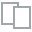
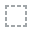
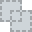
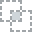
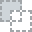
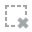
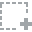
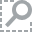
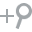
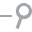
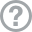
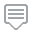
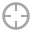
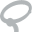
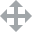
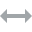
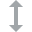
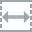
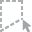
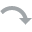
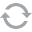
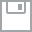
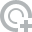
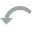
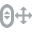
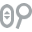
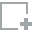
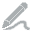
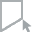
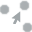
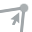
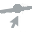

In [ ]:
# Plot Missing Data
plot_missing(data)

## 5. Check Duplicates

In [ ]:
# Cek Total Nilai Duplikat pada Subset Kolom shopee_tweet
data.duplicated(subset=['shopee_tweet']).value_counts()

True     40068
False    11424
dtype: int64

## 6. Drop Duplicates

In [ ]:
# Hapus Nilai Duplikat pada Subset Kolom shopee_tweet
data.drop_duplicates(subset=['shopee_tweet'],inplace=True)

In [ ]:
# Cek Total Data Duplikat Setelah Dihapus
print(f"Total Data Duplikat Terkini : {data.duplicated(subset=['shopee_tweet']).sum()}")

Total Data Duplikat Terkini : 0


## 7. Plot Data


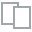
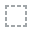
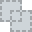
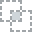
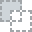
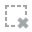
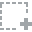
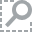
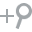
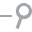
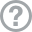
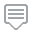
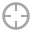
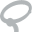
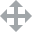
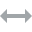
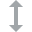
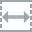
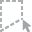
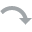
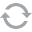
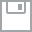
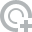
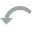
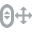
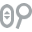
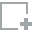
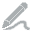
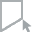
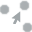
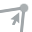
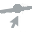

In [ ]:
plot(data)

## 8. Delete Unnecessary Column

In [ ]:
data.drop('tweet_date', axis = 1, inplace=True)

# Data Pre-processing

## 1. Fitering

The first step of preprocessing is to clean the raw tweet data from unnecessary characters, numbers, symbols, etc.

In [ ]:
# Ambil kumpulan stop words berbahasa inggris
nltk.download('punkt')
stop_word = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def clean_tweet(teks):
    teks = re.sub(r'@[A-Za-z0-9_]+', '', str(teks))
    teks = re.sub(r'#', '', str(teks))
    teks = re.sub(r'RT : ', '', str(teks))
    teks = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', str(teks))
    teks = re.sub(r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)", '', str(teks))
    teks = re.sub(r'xe[A-Za-z0-9_]+', '', str(teks))
    teks = re.sub(r'x[A-Za-z0-9_]+', '', str(teks))
    teks = re.sub('(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', '', str(teks))
    teks = teks.translate(str.maketrans("","",string.punctuation))
    # Tokenisasi Kata
    token = word_tokenize(teks)
    # Menghapus stop words
    token_final = [kata for kata in token if kata not in stop_word]
    # Memecah setiap kata menjadi beberapa bagian terpisah 
    word_Lemm = WordNetLemmatizer()
    word_final = []
    for kata in token_final:
      if len(kata)>1:
        kataa = word_Lemm.lemmatize(kata)
        word_final.append(kataa)
    return ' '.join(word_final)

In [ ]:
df = data.copy()
df['shopee_tweet'] = df['shopee_tweet'].apply(clean_tweet)

### Before cleaning

In [ ]:
data

,id_user,shopee_tweet
0,1199264475443937281,RT @ShopeeID: Sambut tahun baru 2022 bersama k...
1,1299243372540952576,RT @ShopeeID: \xf0\x9f\xa7\xa1 OPPO X ASSC GIV...
2,1389400559673778176,RT @nikisbuggeopang: 121921 Shopee Fancall \n\...
5,896159328452739072,Enjoy up to 45% OFF Shopee Voucher \xe2\x87\x9...
6,1127807019409260544,RT @Humalife_: Rekomendasi parfum cowok pemika...
...,...,...
51459,1311267787432554498,"Ini ukuran 13,5cm gitu standarr si kak. Beliny..."
51462,880393829160960001,RT @bakulalkes: Hampers SnackBox \xf0\x9f\x8e\...
51463,2527378165,kung ano ano nanaman nakikita ko sa shopee \xf...
51487,1350761500701413377,wts jisung deco selca\n90k\n\ninc packing \nbs...


### After cleaning

In [ ]:
df

,id_user,shopee_tweet
0,1199264475443937281,Sambut tahun baru 2022 bersama keseruan Shopee...
1,1299243372540952576,OPPO ASSC GIVEAWAY nnSobat Shopee Hari ini Mim...
2,1389400559673778176,121921 Shopee Fancall nnI keep going niki ate ...
5,896159328452739072,Enjoy 45 OFF Shopee Voucher 100 WorkingnnShope...
6,1127807019409260544,Rekomendasi parfum cowok pemikat cewek Di shop...
...,...,...
51459,1311267787432554498,Ini ukuran 135cm gitu standarr si kak Belinya ...
51462,880393829160960001,Hampers SnackBox nONLY 15KnCocok untuk kado ul...
51463,2527378165,kung ano ano nanaman nakikita ko sa shopee
51487,1350761500701413377,wts jisung deco selcan90knninc packing nb shop...


## 2. Subjectivity and Polarity

In [ ]:
def subjektifitas_teks(teks):
    return TextBlob(teks).sentiment.subjectivity

def polaritas_teks(teks):
    return TextBlob(teks).sentiment.polarity

In [ ]:
df['Subjectivity'] = df['shopee_tweet'].apply(subjektifitas_teks)
df['Polarity'] = df['shopee_tweet'].apply(polaritas_teks)

In [ ]:
df.head(10)

,id_user,shopee_tweet,Subjectivity,Polarity
0,1199264475443937281,Sambut tahun baru 2022 bersama keseruan Shopee...,0.454545,0.136364
1,1299243372540952576,OPPO ASSC GIVEAWAY nnSobat Shopee Hari ini Mim...,0.000000,0.000000
2,1389400559673778176,121921 Shopee Fancall nnI keep going niki ate ...,0.600000,0.500000
5,896159328452739072,Enjoy 45 OFF Shopee Voucher 100 WorkingnnShope...,0.500000,0.400000
6,1127807019409260544,Rekomendasi parfum cowok pemikat cewek Di shop...,0.300000,1.000000
7,1131356833300402176,Giveaway photocard chenlenn,0.000000,0.000000
8,1094083497566756864,Gantungan kunci Keychain SEVENTEEN di SHOPEEnn...,0.000000,0.000000
9,1458421310237786118,YOU HAVE STOLEN MY HEART SHOPEE ShopeeHoliDaeb...,0.000000,0.000000
10,1261551584,GUYS STOP KEJAP BUY THINGS ONLINEEE SHOPEE OR ...,0.000000,0.000000
12,1256544535179481089,WTS ina Open SharingnnSLOWACID TEDDY ISLAND TA...,0.500000,0.000000


## 3. Analyze Text Polarity

In [ ]:
def analisis_teks(polarity):
    if polarity > 0:
        return "Positif"
    elif polarity == 0:
        return "Netral"
    else:
        return "Negatif"

In [ ]:
df['Score'] = df['Polarity'].apply(analisis_teks)

In [ ]:
df.head()

,id_user,shopee_tweet,Subjectivity,Polarity,Score
0,1199264475443937281,Sambut tahun baru 2022 bersama keseruan Shopee...,0.454545,0.136364,Positif
1,1299243372540952576,OPPO ASSC GIVEAWAY nnSobat Shopee Hari ini Mim...,0.000000,0.000000,Netral
2,1389400559673778176,121921 Shopee Fancall nnI keep going niki ate ...,0.600000,0.500000,Positif
5,896159328452739072,Enjoy 45 OFF Shopee Voucher 100 WorkingnnShope...,0.500000,0.400000,Positif
6,1127807019409260544,Rekomendasi parfum cowok pemikat cewek Di shop...,0.300000,1.000000,Positif


In [ ]:
# Count the total percentage of positive, negative, and netral tweets
def tweet_condition(data):

  persentase_positif = str(data[data['Score'] == 'Positif'].shape[0]/(data.shape[0])*100) + ' %'
  persentase_netral = str(data[data['Score'] == 'Netral'].shape[0]/(data.shape[0])*100) + ' %'
  persentase_negatif = str(data[data['Score'] == 'Negatif'].shape[0]/(data.shape[0])*100) + ' %'

  return pd.DataFrame([persentase_positif,persentase_netral,persentase_negatif],index = ['Positif','Netral','Negatif'],columns = {'Tweet'})

In [ ]:
tweet_condition(df)

,Tweet
Positif,12.587535014005603 %
Netral,84.29621848739495 %
Negatif,3.11624649859944 %


# Dislay the top 10 words related to shopee tweets.


In [ ]:
from collections import Counter

def getMostFreqWord(data):
    mostfreq = Counter(" ".join(data["shopee_tweet"]).split()).most_common(20)

    mostfreq_filtered = {}
    for i in mostfreq:
        if(i[0] == 'user' or i[0] == 'url' or i[0] == 'rt'):
            continue
        else:
            mostfreq_filtered[i[0]] = i[1]
            if(len(mostfreq_filtered) == 10): 
                break

    return mostfreq_filtered

In [ ]:
most_freq = getMostFreqWord(df)
mostfreq = pd.DataFrame(most_freq, index = list(range(0,11))).T.iloc[:,[0]]
mostfreq.columns = ['Total_Tweet']
mostfreq

,Total_Tweet
shopee,3423
Shopee,2445
Bismillah,1304
aku,1233
di,1108
na,1015
ini,972
po,945
bisa,895
yang,757


## Tokenization

Split a text into token of words.

In [ ]:
df['shopee_tweet']=df['shopee_tweet'].apply(lambda x: " ".join([kata for kata in x.split() if len(kata)>3]))
df.head(5)

,id_user,shopee_tweet,Subjectivity,Polarity,Score
0,1199264475443937281,Sambut tahun baru 2022 bersama keseruan Shopee...,0.454545,0.136364,Positif
1,1299243372540952576,OPPO ASSC GIVEAWAY nnSobat Shopee Hari Mimin O...,0.000000,0.000000,Netral
2,1389400559673778176,121921 Shopee Fancall keep going niki love dre...,0.600000,0.500000,Positif
5,896159328452739072,Enjoy Shopee Voucher WorkingnnShopeePHnMEGAnon...,0.500000,0.400000,Positif
6,1127807019409260544,Rekomendasi parfum cowok pemikat cewek shopeen...,0.300000,1.000000,Positif


In [ ]:
tokenized_tweet = df['shopee_tweet'].apply(lambda x: x.split())
tokenized_tweet.head(5)

0    [Sambut, tahun, baru, 2022, bersama, keseruan,...
1    [OPPO, ASSC, GIVEAWAY, nnSobat, Shopee, Hari, ...
2    [121921, Shopee, Fancall, keep, going, niki, l...
5    [Enjoy, Shopee, Voucher, WorkingnnShopeePHnMEG...
6    [Rekomendasi, parfum, cowok, pemikat, cewek, s...
Name: shopee_tweet, dtype: object

# Data Visualization

## Visualize Distribution of Tweet Label

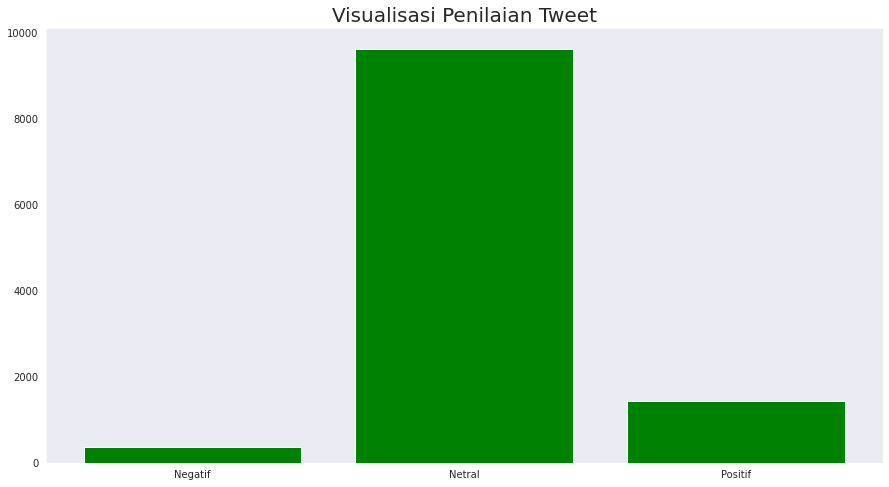

In [ ]:
labels = df.groupby('Score').count().index.values
values = df.groupby('Score').size().values

plt.figure(figsize = (15,8));
plt.bar(labels, values , color = 'green');
plt.title(label = 'Visualisasi Penilaian Tweet',fontdict = {'fontsize' : 20});

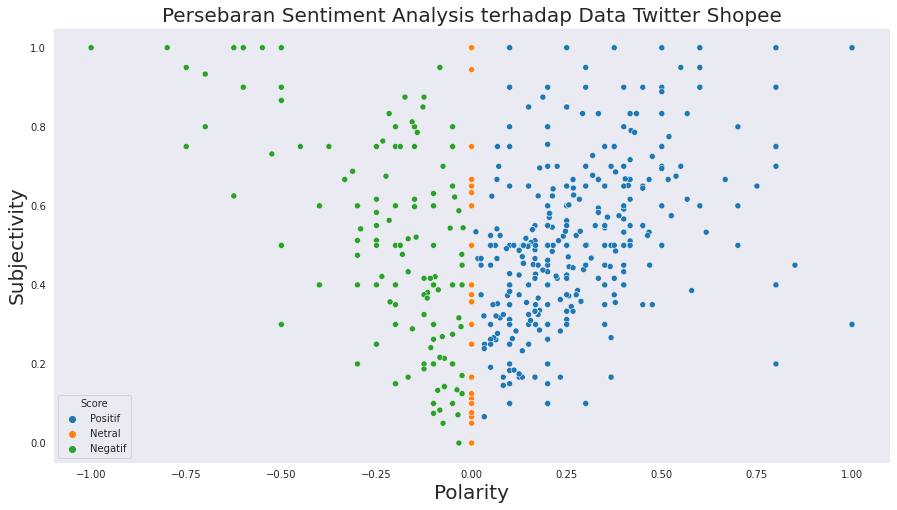

In [ ]:
sns.set_style('dark');
plt.figure(figsize=(15,8));
ax = sns.scatterplot(x = 'Polarity', y = 'Subjectivity', data = df, hue = 'Score')
plt.title(label = 'Persebaran Sentiment Analysis terhadap Data Twitter Shopee', fontdict = {'fontsize' : 20});
plt.xlabel(xlabel = 'Polarity', fontdict = {'fontsize' : 20});
plt.ylabel(ylabel = 'Subjectivity', fontdict = {'fontsize' : 20});

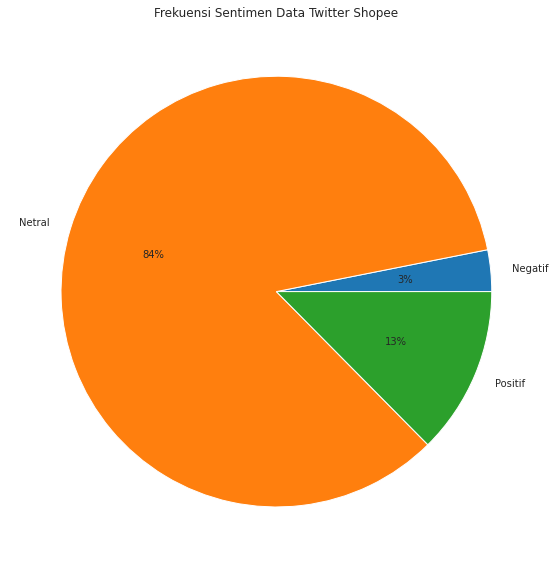

In [ ]:
plt.figure(figsize = (15,8))
fig = plt.pie(df.groupby("Score").size(), labels = df.groupby("Score").size().index, autopct='%.0f%%')
plt.title('Frekuensi Sentimen Data Twitter Shopee')
plt.axis('off')
plt.tight_layout()

In [ ]:
objektif = df[df['Subjectivity'] == 0]

print(str(objektif.shape[0]/(df.shape[0])*100) + " % dari total keseluruhan tweet adalah objektif")

82.17787114845937 % dari total keseluruhan tweet adalah objektif


## Visualize Top 10 Word Occurences

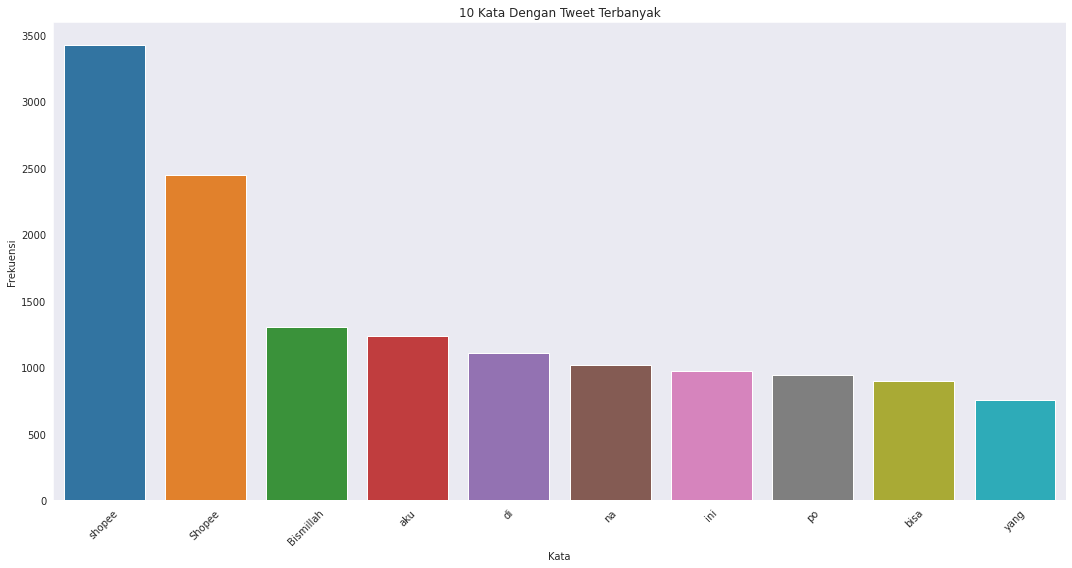

In [ ]:
plt.figure(figsize = (15,8))
fig = sns.barplot(x=list(most_freq.keys()), y=list(most_freq.values()))
plt.xlabel('Kata')
plt.ylabel('Frekuensi')
plt.title('10 Kata Dengan Tweet Terbanyak')
for item in fig.get_xticklabels():
    item.set_rotation(45)
plt.tight_layout()

## Word Cloud 

(-0.5, 799.5, 599.5, -0.5)

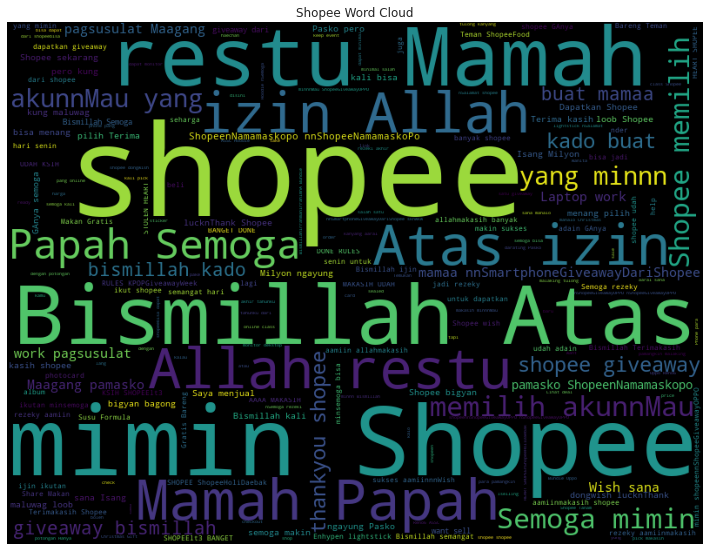

In [ ]:
kata_kata = ' '.join([twt for twt in df['shopee_tweet']])
word_cloud = WordCloud(width=800,
                      height=600,
                      colormap='viridis',
                      collocations=True).generate_from_text(kata_kata)
plt.imshow(word_cloud)
plt.title('Shopee Word Cloud')
plt.tight_layout()
plt.axis('off')

# Data Preparation

In [ ]:
# Subset 
df_new = df[['shopee_tweet','Score']]

In [ ]:
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts = cv.fit_transform(df_new['shopee_tweet'].values.astype('U'))

df_new = shuffle(df_new).reset_index(drop=True)

In [ ]:
# Categorical Encoding
def num_score(score):
  if score == 'Positif':
    return '0'
  elif score == 'Netral':
    return '1'
  else :
    return '2'
df_new['Score_num'] = df_new['Score'].apply(num_score)

In [ ]:
df_new.head()

,shopee_tweet,Score,Score_num
0,Wish sana Isang Milyon ngayung Pasko pero kung...,Netral,1
1,Bismillah Atas izin Allah restu Mamah Papah Se...,Netral,1
2,Bismillah Atas izin Allah restu Mamah Papah Se...,Netral,1
3,stayc phnsoulizsellsnn KpopMerch ShopeeLazada ...,Netral,1
4,dongwish lucknThank Shopee SmartphoneGiveawayD...,Netral,1


# Data Modelling

In this step, we will used Complement Naive Bayes (CNB). Complement Naive Bayes is perfect for working with unbalanced datasets. CNB calculates the probability of an item belongs against all classes.

## 1. Train dan Test Split

In [ ]:
X= text_counts
y= df_new['Score_num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

## 2. Initialize Model 

In [ ]:
cnb = ComplementNB(norm = True)
cnb.fit(X_train, y_train)
cross_cnb = cross_val_score(cnb, X, y,n_jobs = -1)
print("Nilai Cross Validation = ",cross_cnb)                
print("Nilai Akurasi Training ={:.2f}%".format(cnb.score(X_train,y_train)*100))
print("Nilai Akurasi Testing ={:.2f}%".format(cnb.score(X_test,y_test)*100))
train_acc_cnb=cnb.score(X_train,y_train)
test_acc_cnb=cnb.score(X_test,y_test)

Nilai Cross Validation =  [0.7238512  0.74967177 0.75098468 0.71991247 0.72416813]
Nilai Akurasi Training =84.86%
Nilai Akurasi Testing =75.19%


## 3. Predict

In [ ]:
# Prediksi terhadap data test
y_pred = cnb.predict(X_test)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,y_pred))

[[  22  235   21]
 [ 128 1690  125]
 [   1   57    6]]


## 4. Classification Report

In [ ]:
# Memeriksa model dengan classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.15      0.08      0.10       278
           1       0.85      0.87      0.86      1943
           2       0.04      0.09      0.06        64

    accuracy                           0.75      2285
   macro avg       0.35      0.35      0.34      2285
weighted avg       0.74      0.75      0.75      2285



## 5. Precision and Recall

Precision : Precision is defined as the ratio of correctly classified positive samples (True Positive) to a total number of classified positive samples (either correctly or incorrectly).

Recall : Recall is calculated as the ratio between the numbers of positive samples correctly classified as positive samples to the total number of positive samples. The metric measures the model's ability to detect positive samples.

In [ ]:
print("Nilai Presisi: {}".format(precision_score(y_test,y_pred, average = 'weighted')))
print("Nilai Recall: {}".format(recall_score(y_test,y_pred, average = 'weighted')))

Nilai Presisi: 0.8712208698735819
Nilai Recall: 0.8091903719912472
